## **Customer Segmentation - Mall Customers data set**

Data: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

___________________________________________________________________________________________________________________________

#### **1. Data Exploration**
See customer_segmentation _eda.ipynb

___________________________________________________________________________________________________________________________

#### **2. Model Development**

<span style="color:#ed8315">Based on the shape of the data in the correlation plot between <u>Annual_Income and Spending_Score</u> (See EDA file) where we see distinct relatively seperate clusters, I am moving foreword with **k-Means for clustering**</span>

In [104]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

import scipy.stats as stats
import researchpy as rp

from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.graphics.gofplots import qqplot

#### Data Preperation

In [105]:
df = pd.read_csv('data/customers.csv')

# Drop ID Column
df = df.drop(['CustomerID'], axis = 1)

# Based on EDA - drop Gender column
df = df.drop(['Gender'], axis = 1)

In [106]:
df

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


#### Feature Engineering
* As the range for the continuous variables differs **scaling** is requiered
* **Robust-Scaler** was chosen as the data does not seem to be distributed normaly and in one variable there are outliers

In [107]:
# Scale continuous variables
scaler = RobustScaler()

for var in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    newvar_name = 'scaled_' + var
    scaler.fit(df[[var]])
    df[[newvar_name]] = scaler.transform(df[[var]])

In [108]:
df.head()

,Age,Annual Income (k$),Spending Score (1-100),scaled_Age,scaled_Annual Income (k$),scaled_Spending Score (1-100)
0,19,15,39,-0.839506,-1.273973,-0.287582
1,21,15,81,-0.740741,-1.273973,0.810458
2,20,16,6,-0.790123,-1.246575,-1.150327
3,23,16,77,-0.641975,-1.246575,0.705882
4,31,17,40,-0.246914,-1.219178,-0.261438


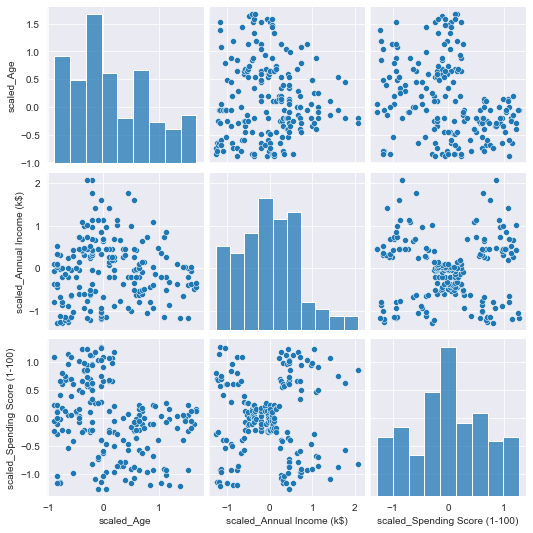

In [109]:
sns.pairplot(df.iloc[:,3:])

#### Clustering with K-Means

***1. Anual Income vs. Spending Score***

**<u>Step 1: Compare and choose k (number of clusters)</u>**

In [110]:
# create df
df_1 = df.iloc[:,4:]

In [111]:
# Clustering Function that checks different cluster numbers (k)
def clustering_alg(data, k):
    k_list = list(range(2, k+1))
    inertia_list=[]
    silhouette_scores = []
    
    for k in k_list:
        model = KMeans(
            n_clusters = k,
            init='k-means++', 
            max_iter=500, 
            random_state=42)
        model.fit(data)
        labels = model.labels_
        inertia_list.append(model.inertia_)
        silhouette_scores.append(metrics.silhouette_score(data, labels))
    
    df_inertia = pd.DataFrame({'k_value': list(range(2, k+1)),
                               'inertia': inertia_list})
    df_silhouette = pd.DataFrame({'k_value': list(range(2, k+1)),
                                  'silhouette_score': silhouette_scores})

    return df_inertia, df_silhouette

In [112]:
# check cluster estimators for 1-10 clusters
df_inertia, df_silhouette = clustering_alg(df_1, 10)

Text(0, 0.5, 'Cluster sum of squared distances (inertia)')

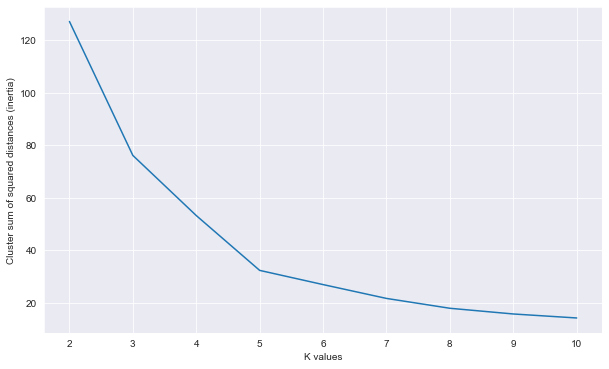

In [113]:
# visualization of k-means and inertia for different k values
plt.figure(figsize= (10, 6))
plt.plot(df_inertia['k_value'], df_inertia['inertia'])
plt.xlabel('K values')
plt.ylabel('Cluster sum of squared distances (inertia)')

Text(0, 0.5, 'silhouette_score')

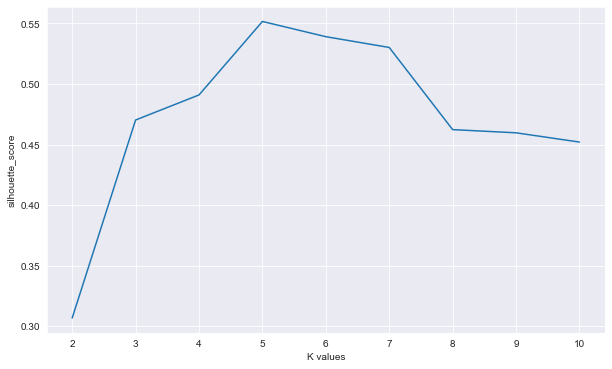

In [114]:
# visualization of k-means and silhouette_scores for different k values
plt.figure(figsize= (10, 6))
plt.plot(df_silhouette['k_value'], df_silhouette['silhouette_score'])
plt.xlabel('K values')
plt.ylabel('silhouette_score')

<span style="color:#ed8315">>>> When **k=5** graph starts to platto and silouette peaks, which matches what was found in the EDA scatter plot</span>

**<u>Step 2: Create final model and extract clusters</u>**

In [115]:
# Compile final model with chosen number of clusters (k = 5)
model_5 = KMeans(
            n_clusters = 5,
            init='k-means++', 
            max_iter=500, 
            random_state=42)

model_5.fit(df_1)

centroids_5 = model_5.cluster_centers_
df_centroids = pd.DataFrame(centroids_5, columns=['X', 'Y'])
labels = model_5.labels_

In [116]:
# Add the resulting cluster labels and the Un-Scaled features to df_1
df_1['label'] = labels
df_1['spending_score'] = df['Spending Score (1-100)']
df_1['anual_income'] = df['Annual Income (k$)']

<AxesSubplot:xlabel='scaled_Annual Income (k$)', ylabel='scaled_Spending Score (1-100)'>

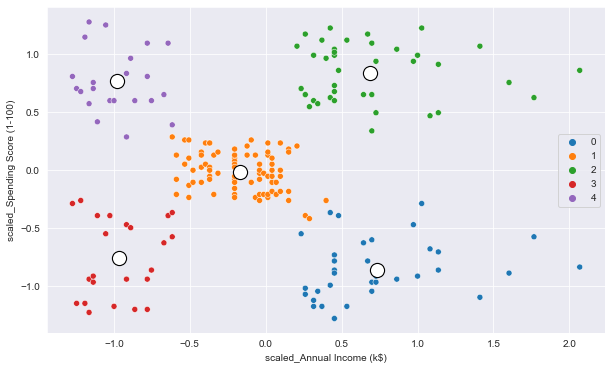

In [117]:
# Visualize Clusters (Scaled Variables with Centroids)
plt.figure(figsize= (10, 6))
sns.set_style("darkgrid")
sns.scatterplot(data=df_1, x='scaled_Annual Income (k$)', y='scaled_Spending Score (1-100)', hue='label', palette='tab10')
sns.scatterplot(data=df_centroids, x='X', y='Y', color='white', edgecolor='black', s=200)

In [118]:
# extracting the group ranges
df_1.groupby('label')['anual_income', 'spending_score'].describe()

C:\Users\maisa\AppData\Local\Temp/ipykernel_23012/3712762575.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_1.groupby('label')['anual_income', 'spending_score'].describe()


anual_income                                                         \
             count       mean        std   min    25%   50%    75%    max   
label                                                                       
0             35.0  88.200000  16.399067  70.0  77.50  85.0  97.50  137.0   
1             81.0  55.296296   8.988109  39.0  48.00  54.0  62.00   76.0   
2             39.0  86.538462  16.312485  69.0  75.50  79.0  95.00  137.0   
3             23.0  26.304348   7.893811  15.0  19.50  25.0  33.00   39.0   
4             22.0  25.727273   7.566731  15.0  19.25  24.5  32.25   39.0   

      spending_score                                                       
               count       mean        std   min   25%   50%    75%   max  
label                                                                      
0               35.0  17.114286   9.952154   1.0  10.0  16.0  23.50  39.0  
1               81.0  49.518519   6.530909  34.0  44.0  50.0  55.00  61.0  
2               39.0  82.128205   9.364489  63.0  74.5  83.0  90.00  97.0  
3               23.0  20.913043  13.017167   3.0   9.5  17.0  33.50  40.0  
4               22.0  79.363636  10.504174  61.0  73.0  77.0  85.75  99.0

<AxesSubplot:xlabel='anual_income', ylabel='spending_score'>

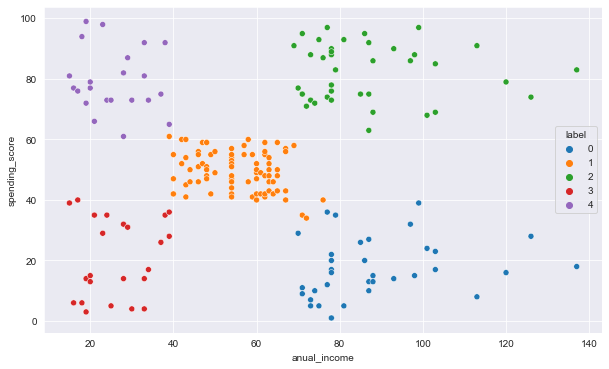

In [119]:
# Visualize clusters with original features
plt.figure(figsize= (10, 6))
sns.set_style("darkgrid")
sns.scatterplot(data=df_1, x='anual_income', y='spending_score', hue='label', palette='tab10')

<span style="color:#ed8315"><u>Customer Segmentation according to **Annual Income - Spending Score**:</u></span>
* <span style="color:#ed8315">**High-Low (0-blue):** Income above 70k and Score under 40 </span>
* <span style="color:#ed8315">**Average-Average (1-orange):** Income between 40k-75k and Score between 35-60 </span>
* <span style="color:#ed8315">**High-High (2-green):** Income above 70k and Score above 60 </span>
* <span style="color:#ed8315">**Low-Low (3-red):** Income under 40k and Score under 40 </span>
* <span style="color:#ed8315">**Low-High (4-purple):** Income under 40k and Score above 60 </span>

**<u>Step 3: Check for statistical significance</u>**

In [120]:
# one-way anova
model = ols("spending_score ~ label", data=df_1).fit()
res = anova_lm(model, typ=1)
res

,df,sum_sq,mean_sq,F,PR(>F)
label,1.0,29944.623349,29944.623349,57.698242,1.185741e-12
Residual,198.0,102759.376651,518.986751,NaN,NaN


<span style="color:#ed8315">>>> Groups are **significantly** not all similar</u></span>

In [121]:
# Tukey’s HSD for group-pair comparisons
comparison = MultiComparison(df_1["spending_score"], df_1["label"])
comparison_results = comparison.tukeyhsd()
comparison_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,32.4042,0.001,27.3343,37.4742,True
0,2,65.0139,0.001,59.1781,70.8498,True
0,3,3.7988,0.5244,-2.929,10.5265,False
0,4,62.2494,0.001,55.43,69.0687,True
1,2,32.6097,0.001,27.7246,37.4947,True
1,3,-28.6055,0.001,-34.5274,-22.6835,True
1,4,29.8451,0.001,23.8193,35.871,True
2,3,-61.2152,0.001,-67.8047,-54.6256,True
2,4,-2.7646,0.759,-9.4476,3.9185,False
3,4,58.4506,0.001,50.976,65.9251,True


<span style="color:#ed8315">>>> Groups are **significanly** different on the scale spending_score, with the **excepsion** of the group pairs 0-High/Low and 3-Low/Low, as well as 2-High/High and 4-Low/High which differ from one another on the scale annual_income </u></span>

c:\Users\maisa\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


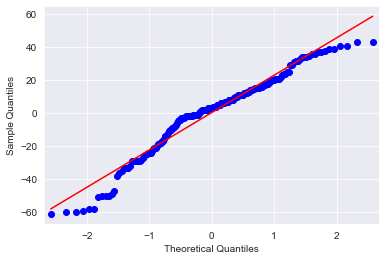

In [122]:
# Normalaty assumption check
residuals = model.resid
plot = qqplot(residuals, line="s")

In [123]:
# t-test for comparison between groups that differ on Annual_Income -  0-High/Low and 3-Low/Low
rp.ttest(group1= df_1['anual_income'][df_1['label'] == 0], group1_name= "label_0",
         group2= df_1['anual_income'][df_1['label'] == 3], group2_name= "label_3")

(   Variable     N       Mean         SD        SE  95% Conf.   Interval
 0   label_0  35.0  88.200000  16.399067  2.771948  82.566723  93.833277
 1   label_3  23.0  26.304348   7.893811  1.645973  22.890808  29.717888
 2  combined  58.0  63.655172  33.426301  4.389088  54.866175  72.444170,
                   Independent t-test  results
 0  Difference (label_0 - label_3) =   61.8957
 1              Degrees of freedom =   56.0000
 2                               t =   16.8285
 3           Two side test p value =    0.0000
 4          Difference < 0 p value =    1.0000
 5          Difference > 0 p value =    0.0000
 6                       Cohen's d =    4.5171
 7                       Hedge's g =    4.4563
 8                   Glass's delta =    3.7743
 9                     Pearson's r =    0.9137)

<span style="color:#ed8315">>>> The two groups are **significantly  different** in annual_income</span>

In [124]:
# t-test for comparison between groups that differ on Annual_Income -  2-High/High and 4-Low/High
rp.ttest(group1= df_1['anual_income'][df_1['label'] == 2], group1_name= "label_2",
         group2= df_1['anual_income'][df_1['label'] == 3], group2_name= "label_4")

(   Variable     N       Mean         SD        SE  95% Conf.   Interval
 0   label_2  39.0  86.538462  16.312485  2.612088  81.250566  91.826357
 1   label_4  23.0  26.304348   7.893811  1.645973  22.890808  29.717888
 2  combined  62.0  64.193548  32.384391  4.112822  55.969453  72.417644,
                   Independent t-test  results
 0  Difference (label_2 - label_4) =   60.2341
 1              Degrees of freedom =   60.0000
 2                               t =   16.5615
 3           Two side test p value =    0.0000
 4          Difference < 0 p value =    1.0000
 5          Difference > 0 p value =    0.0000
 6                       Cohen's d =    4.3541
 7                       Hedge's g =    4.2994
 8                   Glass's delta =    3.6925
 9                     Pearson's r =    0.9058)

<span style="color:#ed8315">>>> The two groups are **significantly  different** in annual_income</span>

***2. Age vs. Spending Score***

**<U>Step 1: Finding the Clusters:</U>**

In [125]:
# Create data frame
df_2 = df.iloc[:,3:]
df_2 = df_2.drop(['scaled_Annual Income (k$)'], axis = 1)

In [126]:
# check cluster estimators for 1-10 clusters
df2_inertia, df2_silhouette = clustering_alg(df_2, 10)

Text(0, 0.5, 'Cluster sum of squared distances (inertia)')

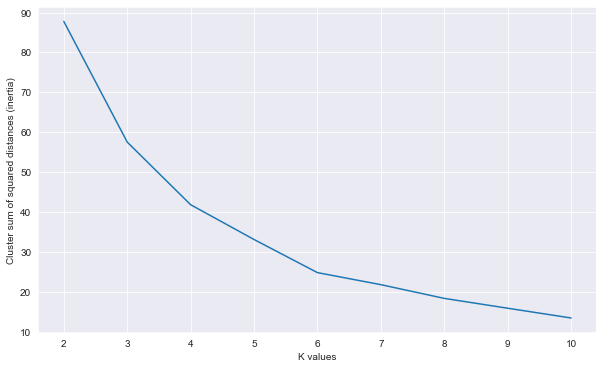

In [127]:
# visualization of k-means and inertia for different k values
# plt.figure(figsize= (10, 6))
plt.plot(df2_inertia['k_value'], df2_inertia['inertia'])
plt.xlabel('K values')
plt.ylabel('Cluster sum of squared distances (inertia)')

Text(0, 0.5, 'silhouette_score')

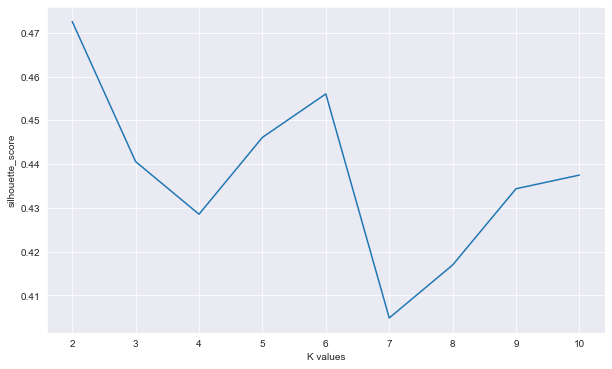

In [128]:
# visualization of k-means and silhouette_scores for different k values
plt.figure(figsize= (10, 6))
plt.plot(df2_silhouette['k_value'], df2_silhouette['silhouette_score'])
plt.xlabel('K values')
plt.ylabel('silhouette_score')

<span style="color:#ed8315">>>> Here we can see that when **k=6** the interia graph starts to platto, however according the silouette graph peaks when **k=2**. Follows I will visualize both options to decide which one is a better fit</span>

**<u>Step 2: Compare models and choose best fit</u>**

In [129]:
# model with k = 2
model_2 = KMeans(
            n_clusters = 2,
            init='k-means++', 
            max_iter=500, 
            random_state=42)

model_2.fit(df_2)

centroids_2 = model_2.cluster_centers_
df2_centroids = pd.DataFrame(centroids_2, columns=['X', 'Y'])
labels2 = model_2.labels_

In [130]:
df_2['label'] = labels2

<AxesSubplot:xlabel='scaled_Age', ylabel='scaled_Spending Score (1-100)'>

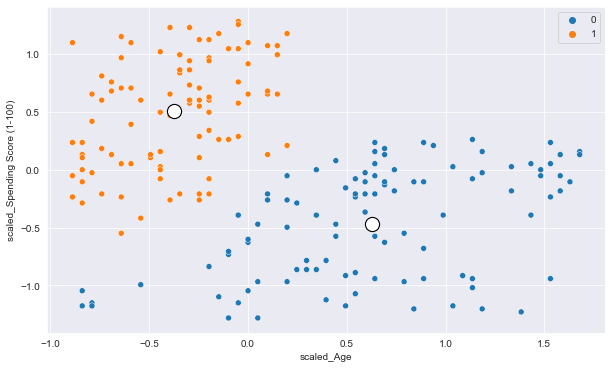

In [131]:
# Visualize Clusters (Scaled Variables with Centroids)
plt.figure(figsize= (10, 6))
sns.set_style("darkgrid")
sns.scatterplot(data=df_2, x='scaled_Age', y='scaled_Spending Score (1-100)', hue='label')
sns.scatterplot(data=df2_centroids, x='X', y='Y', color='white', edgecolor='black', s=200)

In [132]:
df_6 = df_2.drop(['label'], axis = 1)

In [133]:
# model with k = 6
model_6 = KMeans(
            n_clusters = 6,
            init='k-means++', 
            max_iter=500, 
            random_state=42)

model_6.fit(df_6)

centroids_6 = model_6.cluster_centers_
df6_centroids = pd.DataFrame(centroids_6, columns=['X', 'Y'])
labels6 = model_6.labels_

In [134]:
df_6['label'] = labels6

<AxesSubplot:xlabel='scaled_Age', ylabel='scaled_Spending Score (1-100)'>

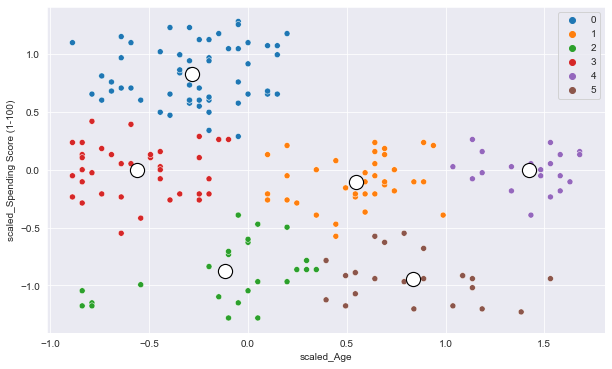

In [135]:
# Visualize Clusters (Scaled Variables with Centroids)
plt.figure(figsize= (10, 6))
sns.set_style("darkgrid")
sns.scatterplot(data=df_6, x='scaled_Age', y='scaled_Spending Score (1-100)', hue='label', palette='tab10')
sns.scatterplot(data=df6_centroids, x='X', y='Y', color='white', edgecolor='black', s=200)

<span style="color:#ed8315">>>> Out of the two visulaisations, **k=2** seems like a btter fit for the data</span>

**<u>Step 3: Visualize final model and extract clusters</u>**

In [136]:
# Add the Un-Scaled features to df_2
df_2['spending_score'] = df['Spending Score (1-100)']
df_2['age'] = df['Age']

<AxesSubplot:xlabel='age', ylabel='spending_score'>

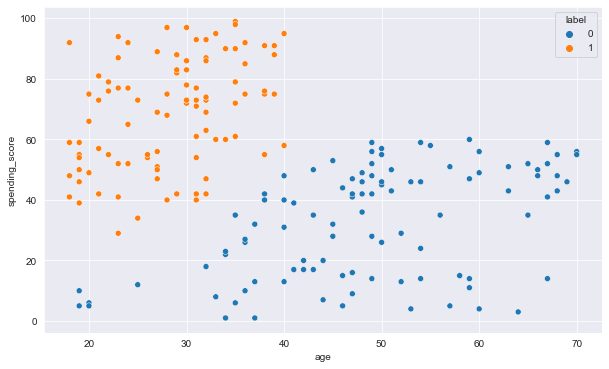

In [143]:
# Visualize clusters with original features
plt.figure(figsize= (10, 6))
sns.set_style("darkgrid")
sns.scatterplot(data=df_2, x='age', y='spending_score', hue='label', palette='tab10')

In [138]:
# extracting the group ranges
df_2.groupby('label')['age', 'spending_score'].describe()

C:\Users\maisa\AppData\Local\Temp/ipykernel_23012/3592973705.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_2.groupby('label')['age', 'spending_score'].describe()


age                                                      \
       count       mean        std   min   25%   50%   75%   max   
label                                                              
0      103.0  48.728155  11.931335  19.0  41.0  49.0  57.5  70.0   
1       97.0  28.360825   6.113826  18.0  23.0  29.0  32.0  40.0   

      spending_score                                                      
               count       mean        std   min   25%   50%   75%   max  
label                                                                     
0              103.0  32.184466  17.954598   1.0  15.0  35.0  48.0  60.0  
1               97.0  69.329897  17.939552  29.0  55.0  73.0  85.0  99.0

<span style="color:#ed8315"><u>Customer Segmentation according to **Age - Spending Score**:</u></span>
* <span style="color:#ed8315">**Under 40** years old (0-blue)</span>
* <span style="color:#ed8315">**Above 40** years old (1-orange)</span>

**<U>Step 4: Check Statistical Significance</u>**

In [139]:
# prepare df
age_k2 = df
age_k2['label'] = labels2

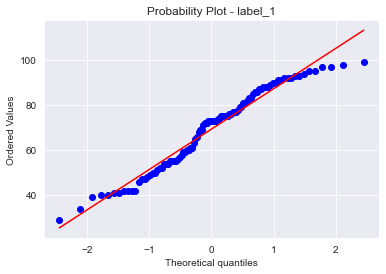

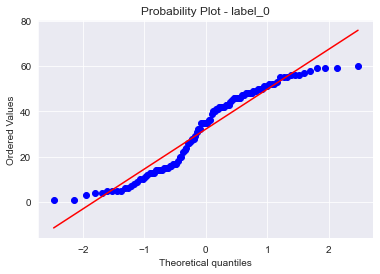

In [140]:
# Check if clusters are normaly distributed
unique_labels = age_k2['label'].unique()

for i in unique_labels:
    stats.probplot(age_k2[age_k2['label'] == i]['Spending Score (1-100)'], dist="norm", plot=plt)
    plt.title("Probability Plot - " + 'label_' + str(i))
    plt.show()

In [141]:
# t-test for comparison between groups
rp.ttest(group1= age_k2['Spending Score (1-100)'][df['label'] == 0], group1_name= "label_0",
         group2= age_k2['Spending Score (1-100)'][df['label'] == 1], group2_name= "label_1")

(   Variable      N       Mean         SD        SE  95% Conf.   Interval
 0   label_0  103.0  32.184466  17.954598  1.769119  28.675427  35.693505
 1   label_1   97.0  69.329897  17.939552  1.821486  65.714277  72.945517
 2  combined  200.0  50.200000  25.823522  1.825999  46.599210  53.800790,
                   Independent t-test   results
 0  Difference (label_0 - label_1) =   -37.1454
 1              Degrees of freedom =   198.0000
 2                               t =   -14.6284
 3           Two side test p value =     0.0000
 4          Difference < 0 p value =     0.0000
 5          Difference > 0 p value =     1.0000
 6                       Cohen's d =    -2.0697
 7                       Hedge's g =    -2.0618
 8                   Glass's delta =    -2.0689
 9                     Pearson's r =     0.7207)

<span style="color:#ed8315">>>> The two clusters are **significantly  different** in Spending_Score</span>

___________________________________________________________________________________________________________________________

#### **Summary**


Based on the **Annual_Income** measure five segments of customers were identified in relation to **Spending_Score** that are defined according to a combination of their tendancy (High/Low) on both their annual income and their spending score as follows:
* <u>High-Low:</u> Income above 70k and Score under 40
* <u>Average-Average:</u> Income between 40k-75k and Score between 35-60
* <u>High-High:</u> Income above 70k and Score above 60
* <u>Low-Low:</u> Income under 40k and Score under 40
* <u>Low-High:</u> Income under 40k and Score above 60

Based on the **Age** measure two segments of customers were identified in relation to **Spending_Score**:
* <u>Under</u> 40 years old
* <u>Above 40</u> years old